In [129]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.optimizers import Adam

In [2]:
# Load the data
file_path = "C:\\Users\\alan\\Medical Image Project\\BrEaST-Lesions-USG-clinical-data-Dec-15-2023.xlsx"
text_data = pd.read_excel(file_path)

# filter revelavant columns
text_columns = [
    'Tissue_composition', 'Signs', 'Symptoms', 'Shape', 'Margin', 
    'Echogenicity', 'Posterior_features', 'Halo', 'Calcifications', 
    'Skin_thickening', 'Interpretation', 'Diagnosis', 'Classification'
]

# Combine textual columns
text_data['combined_text'] = text_data[text_columns].apply(lambda x: ' '.join(x.dropna().astype(str)), axis=1)
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data['combined_text'])

# Create a DataFrame with TF-IDF features, including 'Image_filename' and 'Classification'
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df['Image_filename'] = text_data['Image_filename']
tfidf_df['Classification'] = text_data['Classification']

# Filter out cases with 'Classification' not being 'benign' or 'malignant'
filtered_df = tfidf_df[tfidf_df['Classification'].isin(['benign', 'malignant'])]

print(filtered_df.shape)
filtered_df.head()

(252, 125)


,abscess,adenoma,adenosis,alh,anechoic,angular,apocrine,applicable,atypical,available,...,suspicion,tubular,tumor,type,udh,usual,warmth,yes,Image_filename,Classification
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111090,0.0,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.106777,case001.png,benign
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.346728,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,case002.png,benign
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.00000,0.0,0.0,0.0,0.264102,0.264102,0.0,0.000000,case003.png,benign
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.322107,0.0,0.000000,...,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,case004.png,benign
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.08985,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,case005.png,malignant


In [3]:
Image_file_path = "C:\\Users\\alan\\Medical Image Project"

In [4]:
# Load the CNN model
cnn_model = load_model("C:/Users/alan/Medical Image Project/CNN model.h5")

In [5]:
def extract_image_features(image_path, cnn_model):
    # Load the image file, resizing it
    img = image.load_img(image_path, target_size=(256, 256))  # Adjusted target_size to (256, 256)
    
    # Convert the image to a numpy array
    img_array = image.img_to_array(img)
    
    # Expand dimensions
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    
    # Preprocess the image
    preprocessed_img = preprocess_input(img_array_expanded_dims)
    
    # Extract features using the CNN model
    features = cnn_model.predict(preprocessed_img)
    
    # Return the extracted features
    return features.flatten()


In [6]:
# combined features (textual + image) and labels
combined_features = []
labels = []

# Base path
base_image_path = "C:\\Users\\alan\\Medical Image Project\\combine_data\\"

# Iterate over each row in the DataFrame
for index, row in filtered_df.iterrows():
    # Construct the full path 
    full_image_path = base_image_path + row['Image_filename']
    
    # Extract features
    img_features = extract_image_features(full_image_path, cnn_model)
    
    # Combine with textual TF-IDF features
    textual_features = row.drop(['Image_filename', 'Classification']).values
    combined_row_features = np.concatenate((textual_features, img_features))
    
    # Append the combined features
    combined_features.append(combined_row_features)
    
    # store the label
    labels.append(row['Classification'])

# Convert the combined features and labels to a numpy array
combined_features_array = np.array(combined_features)
labels_array = np.array(labels)


1/1 [==============================] - 0s 23ms/step


In [7]:
combined_features_array.shape

(252, 124)

In [8]:
labels_array.shape

(252,)

In [9]:


label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_array)
labels_categorical = to_categorical(labels_encoded)

# Normalize features
features_normalized = combined_features_array.astype(np.float32) / 255.0

# Split the data
X_train, X_test, y_train, y_test = train_test_split(features_normalized, labels_categorical, test_size=0.2, random_state=42)


In [225]:

# Model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1], activation='sigmoid')  # Output layer
])


In [226]:
optimizer = Adam(learning_rate=0.001)  # Set the learning rate to 0.001

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [227]:
history = model.fit(X_train, y_train,
                    epochs=55,
                    batch_size=16,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/55
10/10 [==============================] - 1s 15ms/step - loss: 0.6916 - accuracy: 0.6000 - val_loss: 0.6918 - val_accuracy: 0.5366
Epoch 2/55
10/10 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.6062 - val_loss: 0.6913 - val_accuracy: 0.5366
Epoch 3/55
10/10 [==============================] - 0s 4ms/step - loss: 0.6861 - accuracy: 0.6062 - val_loss: 0.6905 - val_accuracy: 0.5366
Epoch 4/55
10/10 [==============================] - 0s 4ms/step - loss: 0.6797 - accuracy: 0.6062 - val_loss: 0.6903 - val_accuracy: 0.5366
Epoch 5/55
10/10 [==============================] - 0s 4ms/step - loss: 0.6789 - accuracy: 0.6062 - val_loss: 0.6905 - val_accuracy: 0.5366
Epoch 6/55
10/10 [==============================] - 0s 4ms/step - loss: 0.6765 - accuracy: 0.6062 - val_loss: 0.6916 - val_accuracy: 0.5366
Epoch 7/55
10/10 [==============================] - 0s 28ms/step - loss: 0.6755 - accuracy: 0.6062 - val_loss: 0.6930 - val_accuracy: 0.5366
Epoch 8/55
10/10 [

In [228]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 0s - loss: 0.2569 - accuracy: 0.9412 - 21ms/epoch - 10ms/step

Test accuracy: 0.9411764740943909


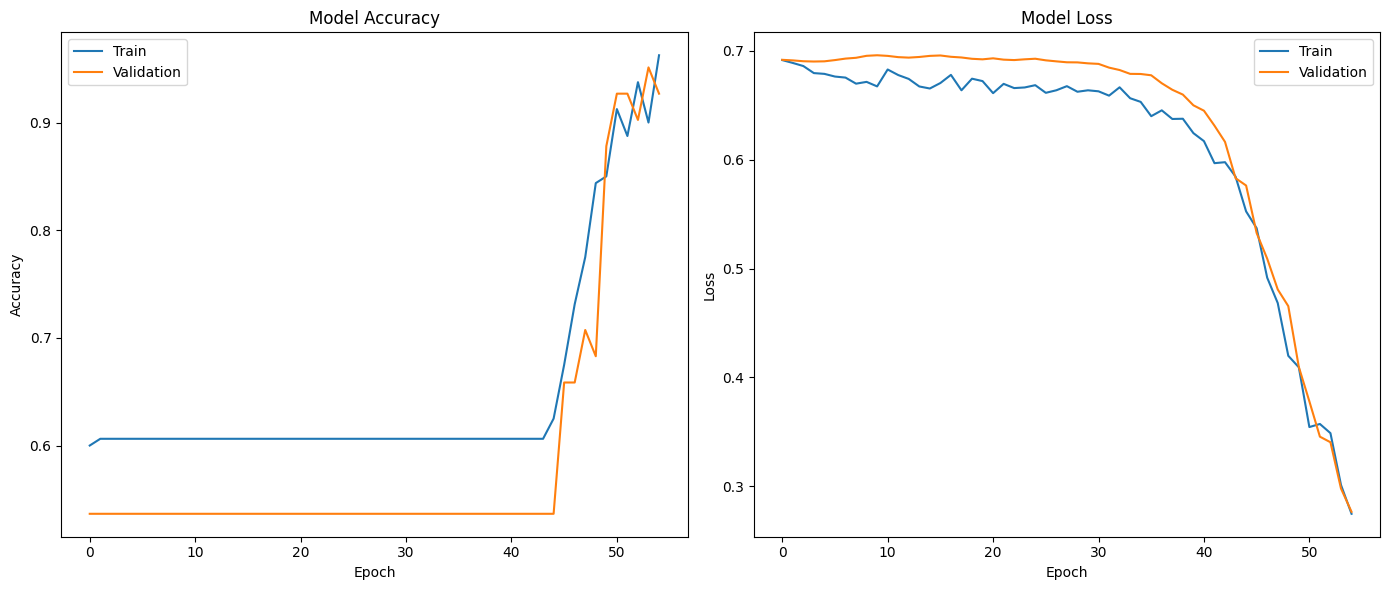

In [229]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()
